In [1]:
import pandas as pd
import numpy as np
import random
import wfdb
import ast
import tensorflow as tf
from tensorflow.keras import layers, models

import os
import matplotlib.pyplot as plt

2024-03-03 21:49:21.097215: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-03 21:49:21.127342: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 21:49:21.127362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 21:49:21.128889: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 21:49:21.135995: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
# from pathlib import Path
path = "/home/zfenton/my_project/ml_project/path/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"
sampling_rate = 100

In [4]:
# load and convert annotation data
# Y = pd.read_csv("/home/zfenton/my_project/ml_project/path/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv", index_col="ecg_id")
Y = pd.read_csv(path + "ptbxl_database.csv", index_col="ecg_id")
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [5]:
X = load_raw_data(Y, sampling_rate, path)

In [6]:
agg_df = pd.read_csv(path + "scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [7]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [8]:
# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [9]:
y_train.value_counts()

[NORM]                 8157
[MI]                   2276
[STTC]                 2158
[CD]                   1524
[MI, CD]               1164
[STTC, HYP]             708
[MI, STTC]              538
[HYP]                   479
[STTC, CD]              433
[]                      371
[NORM, CD]              362
[MI, STTC, HYP]         320
[HYP, CD]               273
[MI, STTC, CD]          202
[STTC, HYP, CD]         186
[MI, HYP]               166
[MI, STTC, HYP, CD]     140
[MI, HYP, CD]           112
[STTC, NORM]             24
[STTC, NORM, CD]          5
[NORM, HYP]               2
[MI, NORM, CD, HYP]       1
Name: diagnostic_superclass, dtype: int64

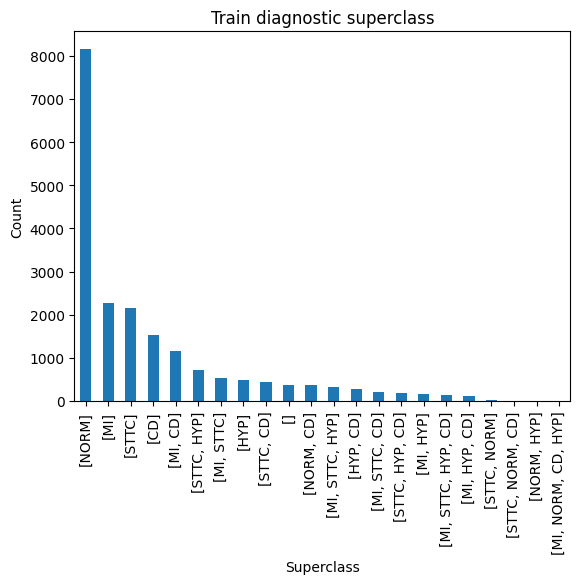

In [10]:
y_train.value_counts().plot(kind='bar')
plt.title("Train diagnostic superclass")
plt.xlabel("Superclass")
plt.ylabel("Count")
plt.show()

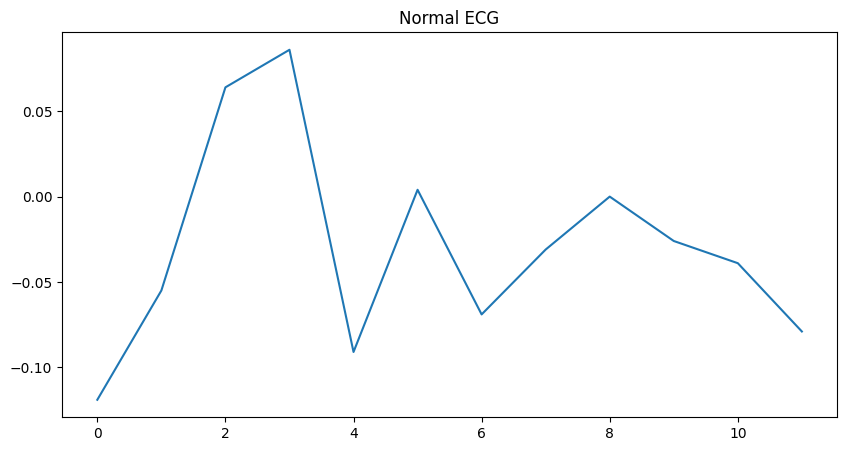

In [11]:
# display 12 lead ECG
def plot_example(data, title, lead):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(data[lead])
    plt.show()
    
plot_example(X_train[0], "Normal ECG", 0)



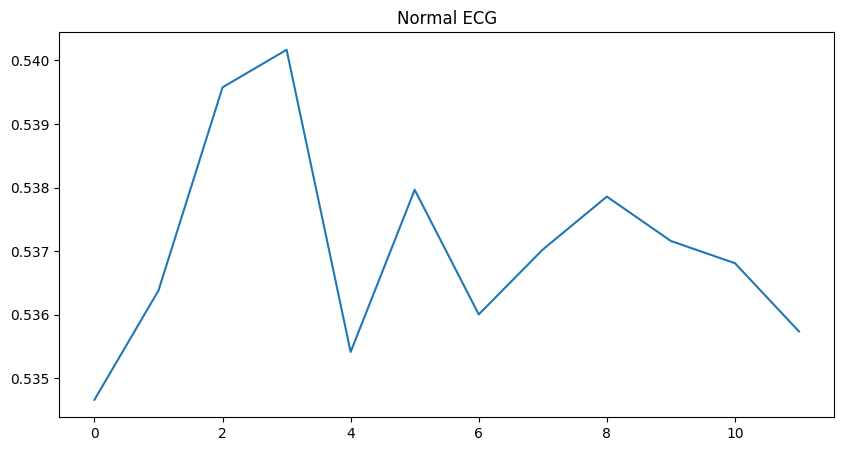

In [12]:
# Normalization
def normalize(data, max_val, min_val):
    return (data - min_val) / (max_val - min_val)

max_val = np.max(X_train)
min_val = np.min(X_train)
X_train_norm = normalize(X_train, max_val, min_val)
X_test_norm = normalize(X_test, max_val, min_val)

plot_example(X_train_norm[0], "Normal ECG", 0)

In [13]:
X_train_norm.shape

(19601, 1000, 12)

In [14]:
# Reshape data
X_train_norm = X_train_norm.reshape(len(X_train_norm), 1000, 12)
X_test_norm = X_test_norm.reshape(len(X_test_norm), 1000, 12)


In [15]:
X_train_norm.shape, X_test_norm.shape

((19601, 1000, 12), (2198, 1000, 12))

In [16]:
# One hot encoding
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)

y_train[0]


array([0, 0, 0, 1, 0])

In [17]:
# Split data into train and validation
from sklearn.model_selection import train_test_split
X_train_re, X_val_re, y_train_re, y_val_re = train_test_split(X_train_norm, y_train, test_size=0.2, random_state=42)


In [18]:
# Model
model = tf.keras.Sequential()

model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(1000, 12)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()


2024-03-03 22:00:51.417539: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-03 22:00:52.416546: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-03 22:00:52.416586: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-03 22:00:52.418697: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-03 22:00:52.418737: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 996, 32)           1952      
                                                                 
 max_pooling1d (MaxPooling1  (None, 498, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 494, 64)           10304     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 247, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 243, 128)          41088     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 121, 128)          0

Epoch 1/5


2024-03-03 22:01:19.363494: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-03 22:01:23.001672: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4ec115ed00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-03 22:01:23.001701: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-03-03 22:01:23.110351: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709532083.352899  574422 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


613/613 [==============================] - 13s 9ms/step - loss: 173678304.0000 - accuracy: 0.2352 - val_loss: 766868352.0000 - val_accuracy: 0.1122
Epoch 2/5
613/613 [==============================] - 4s 6ms/step - loss: 16992559104.0000 - accuracy: 0.2366 - val_loss: 40041062400.0000 - val_accuracy: 0.0895
Epoch 3/5
613/613 [==============================] - 4s 6ms/step - loss: 162971828224.0000 - accuracy: 0.2335 - val_loss: 197330436096.0000 - val_accuracy: 0.1122
Epoch 4/5
613/613 [==============================] - 4s 6ms/step - loss: 710894026752.0000 - accuracy: 0.2359 - val_loss: 1093550604288.0000 - val_accuracy: 0.4262
Epoch 5/5
613/613 [==============================] - 4s 6ms/step - loss: 1938973786112.0000 - accuracy: 0.2329 - val_loss: 2054979977216.0000 - val_accuracy: 0.1395


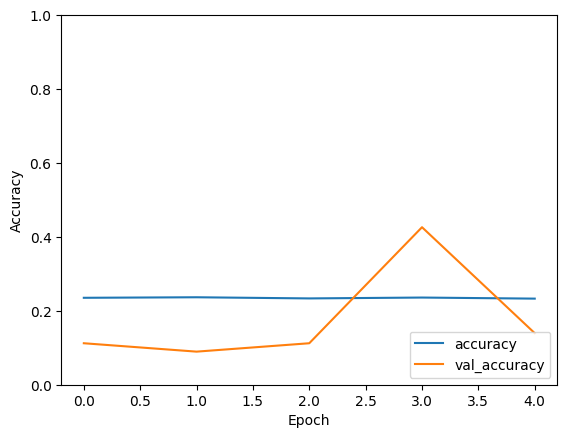

In [20]:
# Train model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val_re, y_val_re))

# plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()